In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.transpiler.passes import RemoveBarriers
from qiskit_aer import AerSimulator
from qiskit import transpile
from numpy.random import rand
import matplotlib.pyplot as plt
import numpy as np
import itertools

# The 5 Qubit Code

## Stabilizer Group and Code Space

The 5-qubit code is defined by its stabilizer group $$\langle XZZXI,IXZZX,XIXZZ,ZXIXZ\rangle.$$ Since the stabilizer group generators all commute and square to $IIIII$, the group they generate is 
\begin{align}
G = \{(XZZXI)^{a_1}(IXZZX)^{a_2}(XIXZZ)^{a_3}(ZXIXZ)^{a_4}:a_i\in\mathbb{F}_2 \}.
\end{align}
It's logical codewards are \begin{align}
\ket{0_L} = \frac{1}{|G|^{1/2}}\sum_{g\in G}  g\ket{00000} = \frac{1}{4}[&\ket{00000} + \ket{10010}+\ket{01001} + \ket{10100}+\ket{01010}-\ket{11011}-\ket{00110}-\ket{11000} \\
&-\ket{11101}-\ket{00011}-\ket{11110}-\ket{01111}-\ket{10001}-\ket{01100}-\ket{10111}+\ket{00101}],\\
\ket{1_L} = \frac{1}{|G|^{1/2}}\sum_{g\in G}  g\ket{11111} = \frac{1}{4}[&\ket{11111}+\ket{01101}+\ket{10110}+\ket{01011}+\ket{10101}-\ket{00100}-\ket{11001}-\ket{00111}\\
&-\ket{00010}-\ket{11100}-\ket{00001}-\ket{10000}-\ket{01110}-\ket{10011}-\ket{01000}+\ket{11010}].
\end{align} By construction, $\ket{0_L}$ and $\ket{1_L}$ are stabilized by the group $G$. Since the encoding of $\ket{0_L}$ and $\ket{1_L}$ are related by swapping $0\leftrightarrow 1$ bitwise, we see that the logical $X$ operator $X_L = XXXXX$ maps between $\ket{0_L}\leftrightarrow\ket{1_L}$ as expected. Similarly, since each term in $\ket{0_L}$ ($\ket{1_L}$) has an even (odd) number of 1's, the logical $Z$ operator $Z_L = ZZZZZ$ has the expected effect of $Z_L\ket{x_L} = (-1)^{x_L}\ket{x_L}$. 


In this notebook we use implement the 5 qubit code to detect/correct single Pauli errors. The first step is to be able to prepare the state $\ket{0_L}$ and $\ket{1_L}$.

In [2]:
def prepare_logical_state(qc,register,val):
    """
    Prepares the logical state |0> or |1> on 5 qubits.

    qc: a quantum circuit
    register: the 5 quantum registers storing the data for our physical qubit
    val: (Int) 0 or 1 corresponding to whether we want to prepare the logical 0 or logical 1 state.
    """

    ## Create two arrays storing the which elements (in decimal notation) of the 
    ## computational basis have a +1/4 or a -1/4 as their coefficient in the |0> state
    
    plus_indices = np.array([0,18,9,20,10,5])
    minus_indices = np.array([27,6,24,29,3,30,15,17,12,23])

    # If we want to prepare the |1> state, we take the binary complement (bitwise swap 0 <-> 1),
    # which corresponds to taking 31 - x in the decimal representation.
    if val == 1:
        plus_indices = 31-plus_indices
        minus_indices = 31-minus_indices

    ## Initialize the state vector to all zeros
    state_vector = np.zeros(2**5,dtype = int)

    ## Replace the appropriate indices in the state vector with a +1 or -1
    for i in plus_indices:
        state_vector[i] = 1

    for i in minus_indices:
        state_vector[i] = -1

    # and normalize
    state_vector = state_vector/np.sqrt(sum(state_vector**2))

    
    # Then initialize these qubits in the state we just computed
    qc.initialize(state_vector,register)


## Test Case:
register = QuantumRegister(size = 5,name = 'x')
qc = QuantumCircuit(register)
prepare_logical_state(qc,register,0)

Statevector(qc).draw('Latex')

<IPython.core.display.Latex object>

## Pauli Error Channel

Next, we need to apply a randomized Pauli error to our state. Recall that a Pauli channel has probability $p$ of implementing an $X$ gate, probability $p$ of implementing a $Y$ gate, and probability $p$ of implementing a $Z$ gate. This leaves probability $1-3p$ of no error occuring. We implement this channel on a single qubit below, and check that this gives the right probability distribution:

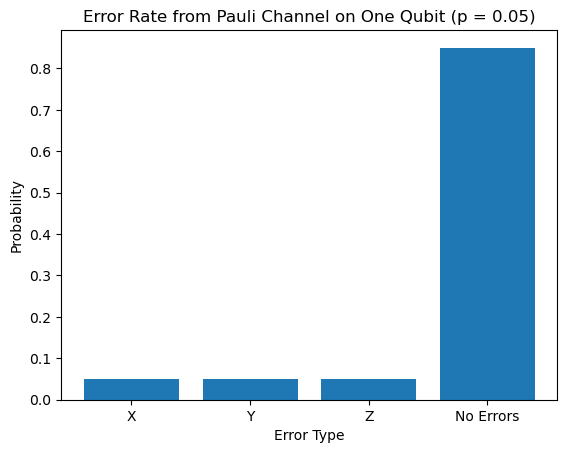

In [3]:
def Pauli_error_channel(qc,register,p):

    """
    Implement a Pauli error on a single qubit.

    qc: a quantum circuit
    register: a quantum register on which the Pauli error occurs with the aforementioned probabilities
    p: (float) a value between 0 and 1/3 denoting the probability of a Pauli error occuring

    Returns: a string "error" denoting which error occured. 
    [For debugging purposes only! This will NOT be used in the error correction!]
    """

    # Create a random number
    x = rand()

    # With probability p, generate an X error
    if x < p:
        qc.x(register)
        error = 'X'

    # With probability p, generate a Y error
    elif p < x and x < 2*p:
        qc.y(register)
        error = 'Y'
        
    # With probability p, generate a Z error    
    elif 2*p < x and x < 3*p:
        qc.z(register)
        error = 'Z'
        
    else:
        error = ''

    # Return the error that occured, if any.

    return error

## Test Case:

# Initialize our qubit and variables to count the number of errors occuring
register = QuantumRegister(size = 1, name = 'x')
qc = QuantumCircuit(register)

x_errors = 0
y_errors = 0
z_errors = 0
no_errors = 0

prob = 0.05
total = int(1e5)

qc.draw(output='mpl')

## Implement the Pauli error channel many times and count how often each error occurs

for i in range(total):
    qc = QuantumCircuit(register)
    error_type = Pauli_error_channel(qc,register,prob)

    if error_type == '':
        no_errors += 1
    elif error_type == 'X':
        x_errors += 1
    elif error_type == 'Y':
        y_errors += 1
    elif error_type == 'Z':
        z_errors += 1
            

## Plot the results:

plt.figure()
plt.bar(['X','Y','Z','No Errors'],[x_errors/total,y_errors/total,z_errors/total,no_errors/total])
plt.xlabel('Error Type')
plt.title(f'Error Rate from Pauli Channel on One Qubit (p = {prob})')
plt.ylabel('Probability')
plt.show()
plt.close()

Notice that on 5 qubits, since we implement the above channel independently on each qubit, there is some probability for multiple errors to occur (e.g. and $X$ error on qubit 0 and qubit 2), but this is of order $p^2$, which is negligible for sufficiently small $p$.

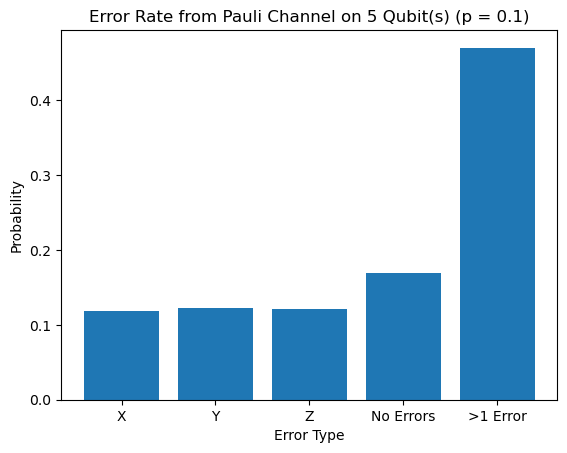

Predicted recovery rate for p = 0.1 is 53.016%.


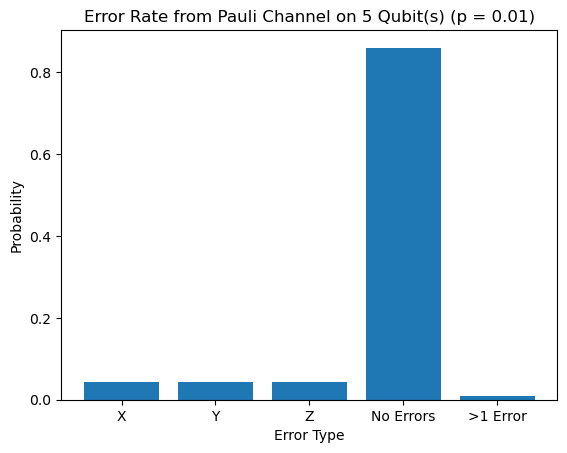

Predicted recovery rate for p = 0.01 is 99.175%.


In [4]:
## Variables to count the errors occuring

x_errors = 0
y_errors = 0
z_errors = 0
no_errors = 0
multiple_errors = 0

# Create a quantum register/circuit to test our Pauli error channel on
register = QuantumRegister(size = 5, name = 'x')
qc = QuantumCircuit(register)

# Set the error rate and total number of trials
prob = 0.1
total = 100000

# Repeatedly run the Pauli error channel on 5 qubits (independently)
# and count the errors

for i in range(total):
    
    
    error_type = ''
    
    for k in range(len(register)):
        error_type += Pauli_error_channel(qc,register[k],prob)

    if len(error_type) > 1:
        multiple_errors +=1 
        
    elif error_type == '':
        no_errors += 1
    elif error_type == 'X':
        x_errors += 1
    elif error_type == 'Y':
        y_errors += 1
    elif error_type == 'Z':
        z_errors += 1

## Plot the results and print the prediceted recovery rate (when # errors <= 1)

plt.figure()
plt.bar(['X','Y','Z','No Errors','>1 Error'],[x_errors/total,y_errors/total,z_errors/total,no_errors/total,multiple_errors/total])
plt.xlabel('Error Type')
plt.title(f'Error Rate from Pauli Channel on {len(register)} Qubit(s) (p = {prob})')
plt.ylabel('Probability')
plt.show()
plt.close()

print(f'Predicted recovery rate for p = {prob} is {(x_errors+y_errors+z_errors+no_errors)/total*100}%.')


# Reinitialize the error count:

x_errors = 0
y_errors = 0
z_errors = 0
no_errors = 0
multiple_errors = 0


# Set the error rate and total number of trials
prob = 0.01
total = 100000

# Repeatedly run the Pauli error channel on 5 qubits (independently)
# and count the errors

for i in range(total):
    
    
    error_type = ''
    
    for k in range(len(register)):
        error_type += Pauli_error_channel(qc,register[k],prob)

    if len(error_type) > 1:
        multiple_errors +=1 
        
    elif error_type == '':
        no_errors += 1
    elif error_type == 'X':
        x_errors += 1
    elif error_type == 'Y':
        y_errors += 1
    elif error_type == 'Z':
        z_errors += 1

## Plot the results and print the prediceted recovery rate (when # errors <= 1)

plt.figure()
plt.bar(['X','Y','Z','No Errors','>1 Error'],[x_errors/total,y_errors/total,z_errors/total,no_errors/total,multiple_errors/total])
plt.xlabel('Error Type')
plt.title(f'Error Rate from Pauli Channel on {len(register)} Qubit(s) (p = {prob})')
plt.ylabel('Probability')
plt.show()
plt.close()

print(f'Predicted recovery rate for p = {prob} is {(x_errors+y_errors+z_errors+no_errors)/total*100}%.')

## Syndrome Checks

The syndrome $\vec s = (s_0,s_1,s_2,s_3) \in {\mathbb{F}_2}^4$ is a list of four binary numbers that encode whether or not the state of a particular set of 5 qubits "passes" each of the checks implemented by the stabilizers; e.g., if $\vec s = (0,0,0,1)$ then $XZZXI,IXZZX,XIXZZ$ all leave the 5 qubits invariant, but $ZXIXZ$ does not. This implies that our error commutes with $XZZXI,IXZZX,XIXZZ$ but not $ZXIXZ$, and so (assuming only a single Pauli error occured) the culprit must be an $X$ error on the first qubit ($XIIII$). Considering all 15 single Pauli errors and computing the commutator with each of the stabilizers, we find the corresponding syndromes for each possible error: \begin{align}
&X_1:0001 &&Z_1:1010 &&& Y_1: 1011\\
&X_2:1000 && Z_2: 0101 &&& Y_2: 1101\\
&X_3:1100 && Z_3: 0010 &&& Y_3:1110\\
&X_4:0100 &&Z_4:1001 &&&Y_4:1111\\
&X_5:0011 &&Z_5:0100 &&&Y_5:0111
\end{align} We encode this data in the following dictionary.

In [5]:
decoding_dictionary = {'0001':'XIIII','1000':'IXIII','1100':'IIXII','0110':'IIIXI','0011':'IIIIX',
                      '1010':'ZIIII','0101':'IZIII','0010':'IIZII','1001':'IIIZI','0100':'IIIIZ',
                      '1011':'YIIII','1101':'IYIII','1110':'IIYII','1111':'IIIYI','0111':'IIIIY'}

We need to design a circuit to compute these syndromes. We design a gate 'check_X' that extracts the eigenvalue of a qubit $\ket{\psi}$ that is in an eigenstate of $X$. Recall that $X\ket{\pm} = \pm1\cdot\ket{\pm}$, where the states $\ket{\pm} \equiv \frac{1}{\sqrt{2}}[\ket{0}\pm \ket{1}]$. Also recall that $H\ket{+} = \ket{0}$ and $H\ket{-} = \ket{1}$. Thus, to record the eigenvalues we act an $H$ gate on our qubit, and use the result as a control for a controlled $X$ gate on our syndrome $\ket{s}$, and then uncompute with an $H$ gate on our original qubit. The resulting $\ket{s}$ will be in the state $\ket{0}$ for the $\ket{+}$ state and $\ket{1}$ for the $\ket{-}$ state, so that $X\ket{\psi} = (-1)^s \ket{\psi}$.

Similarly, we design a 'check_Z' gate that just uses a controlled $X$ get controlled by our qubit acting on the syndrome. This works because the computational basis is already an eigenbasis of $Z$, and $Z\ket{x} = (-1)^x\ket{x}$.

In [6]:
""" 
Define functions check_X and check_Z that are used in the above syndrome check.

qc: a quantum circuit
register: a quantum register
syndrome: a quantum or ancilla register for which the output of the syndrome check will be stored
(i.e. syndrome will be in the |0> state if it "passes" or the |1> state if not.)
"""

def check_X(qc,register,syndrome):
    qc.h(register)
    qc.cx(register,syndrome)
    qc.h(register)

def check_Z(qc,register,syndrome):
    qc.cx(register,syndrome)

To obtain the eigenvalue for a particular stabilizer acting on some eigenstate $\ket{\psi}$, we just successively record the eigenvalues of the individual operators to the same syndrome. If an even number of operators produce a (-1) on the state, the overall effect will cancel and the resulting state will be in the $+1$ eigenspace.

In [7]:
def syndrome_check(qc,register,syndrome,stabilizer_group):
    """
    Implement the syndrome check on the physical qubits, storing the result in the syndrome qubits.

    qc: a quantum circuit
    register: (quantum register) the 5 physical qubits storing our data
    syndrome: (quantum register) the 4 physical qubits storing the results of our syndrome checks 
            [one for each generator of the stabilizer group]
    stabilizer_group: list of strings generated by {X,Y,Z,I} corresponding to the stabilizers of our code space.
    """

    # For the j-th stabilizer...
    for j in range(len(stabilizer_group)):
        
        stabilizer = stabilizer_group[j]

        # Perform an X (cor. Z) check on the i-th qubit if the i-th operator in the stabilizer is X (cor. Z)
        # and record the result to the j-th syndrome qubit.
        
        for i in range(len(register)):
            
            if stabilizer[i] == 'X':
                check_X(qc,register[i],syndrome[j])
                
            elif stabilizer[i] == 'Z':
                check_Z(qc,register[i],syndrome[j])
    
        qc.barrier()

In [8]:
## Test Case: We verify that the code word 0_L produces syndromes 0000: ##
        
register = QuantumRegister(size = 5,name = 'x')
syndrome = AncillaRegister(size = 4, name = 's')
stabilizer_group = ['XZZXI','IXZZX','XIXZZ','ZXIXZ']
qc = QuantumCircuit(register,syndrome)
prepare_logical_state(qc,register,0)
syndrome_check(qc,register,syndrome,stabilizer_group)


Statevector(qc).draw('Latex')

<IPython.core.display.Latex object>

In [9]:
## Test Case: We verify that the code word 1_L all produce syndromes 0000: ##
        
register = QuantumRegister(size = 5,name = 'x')
syndrome = AncillaRegister(size = 4, name = 's')
stabilizer_group = ['XZZXI','IXZZX','XIXZZ','ZXIXZ']
qc = QuantumCircuit(register,syndrome)
prepare_logical_state(qc,register,1)
syndrome_check(qc,register,syndrome,stabilizer_group)


Statevector(qc).draw('Latex')

<IPython.core.display.Latex object>

Finally, we can perform a measurement of the syndrome qubits to diagnose the kind of error that occured, and use the results of our earlier discussion to apply the appropriate gates to correct our error.

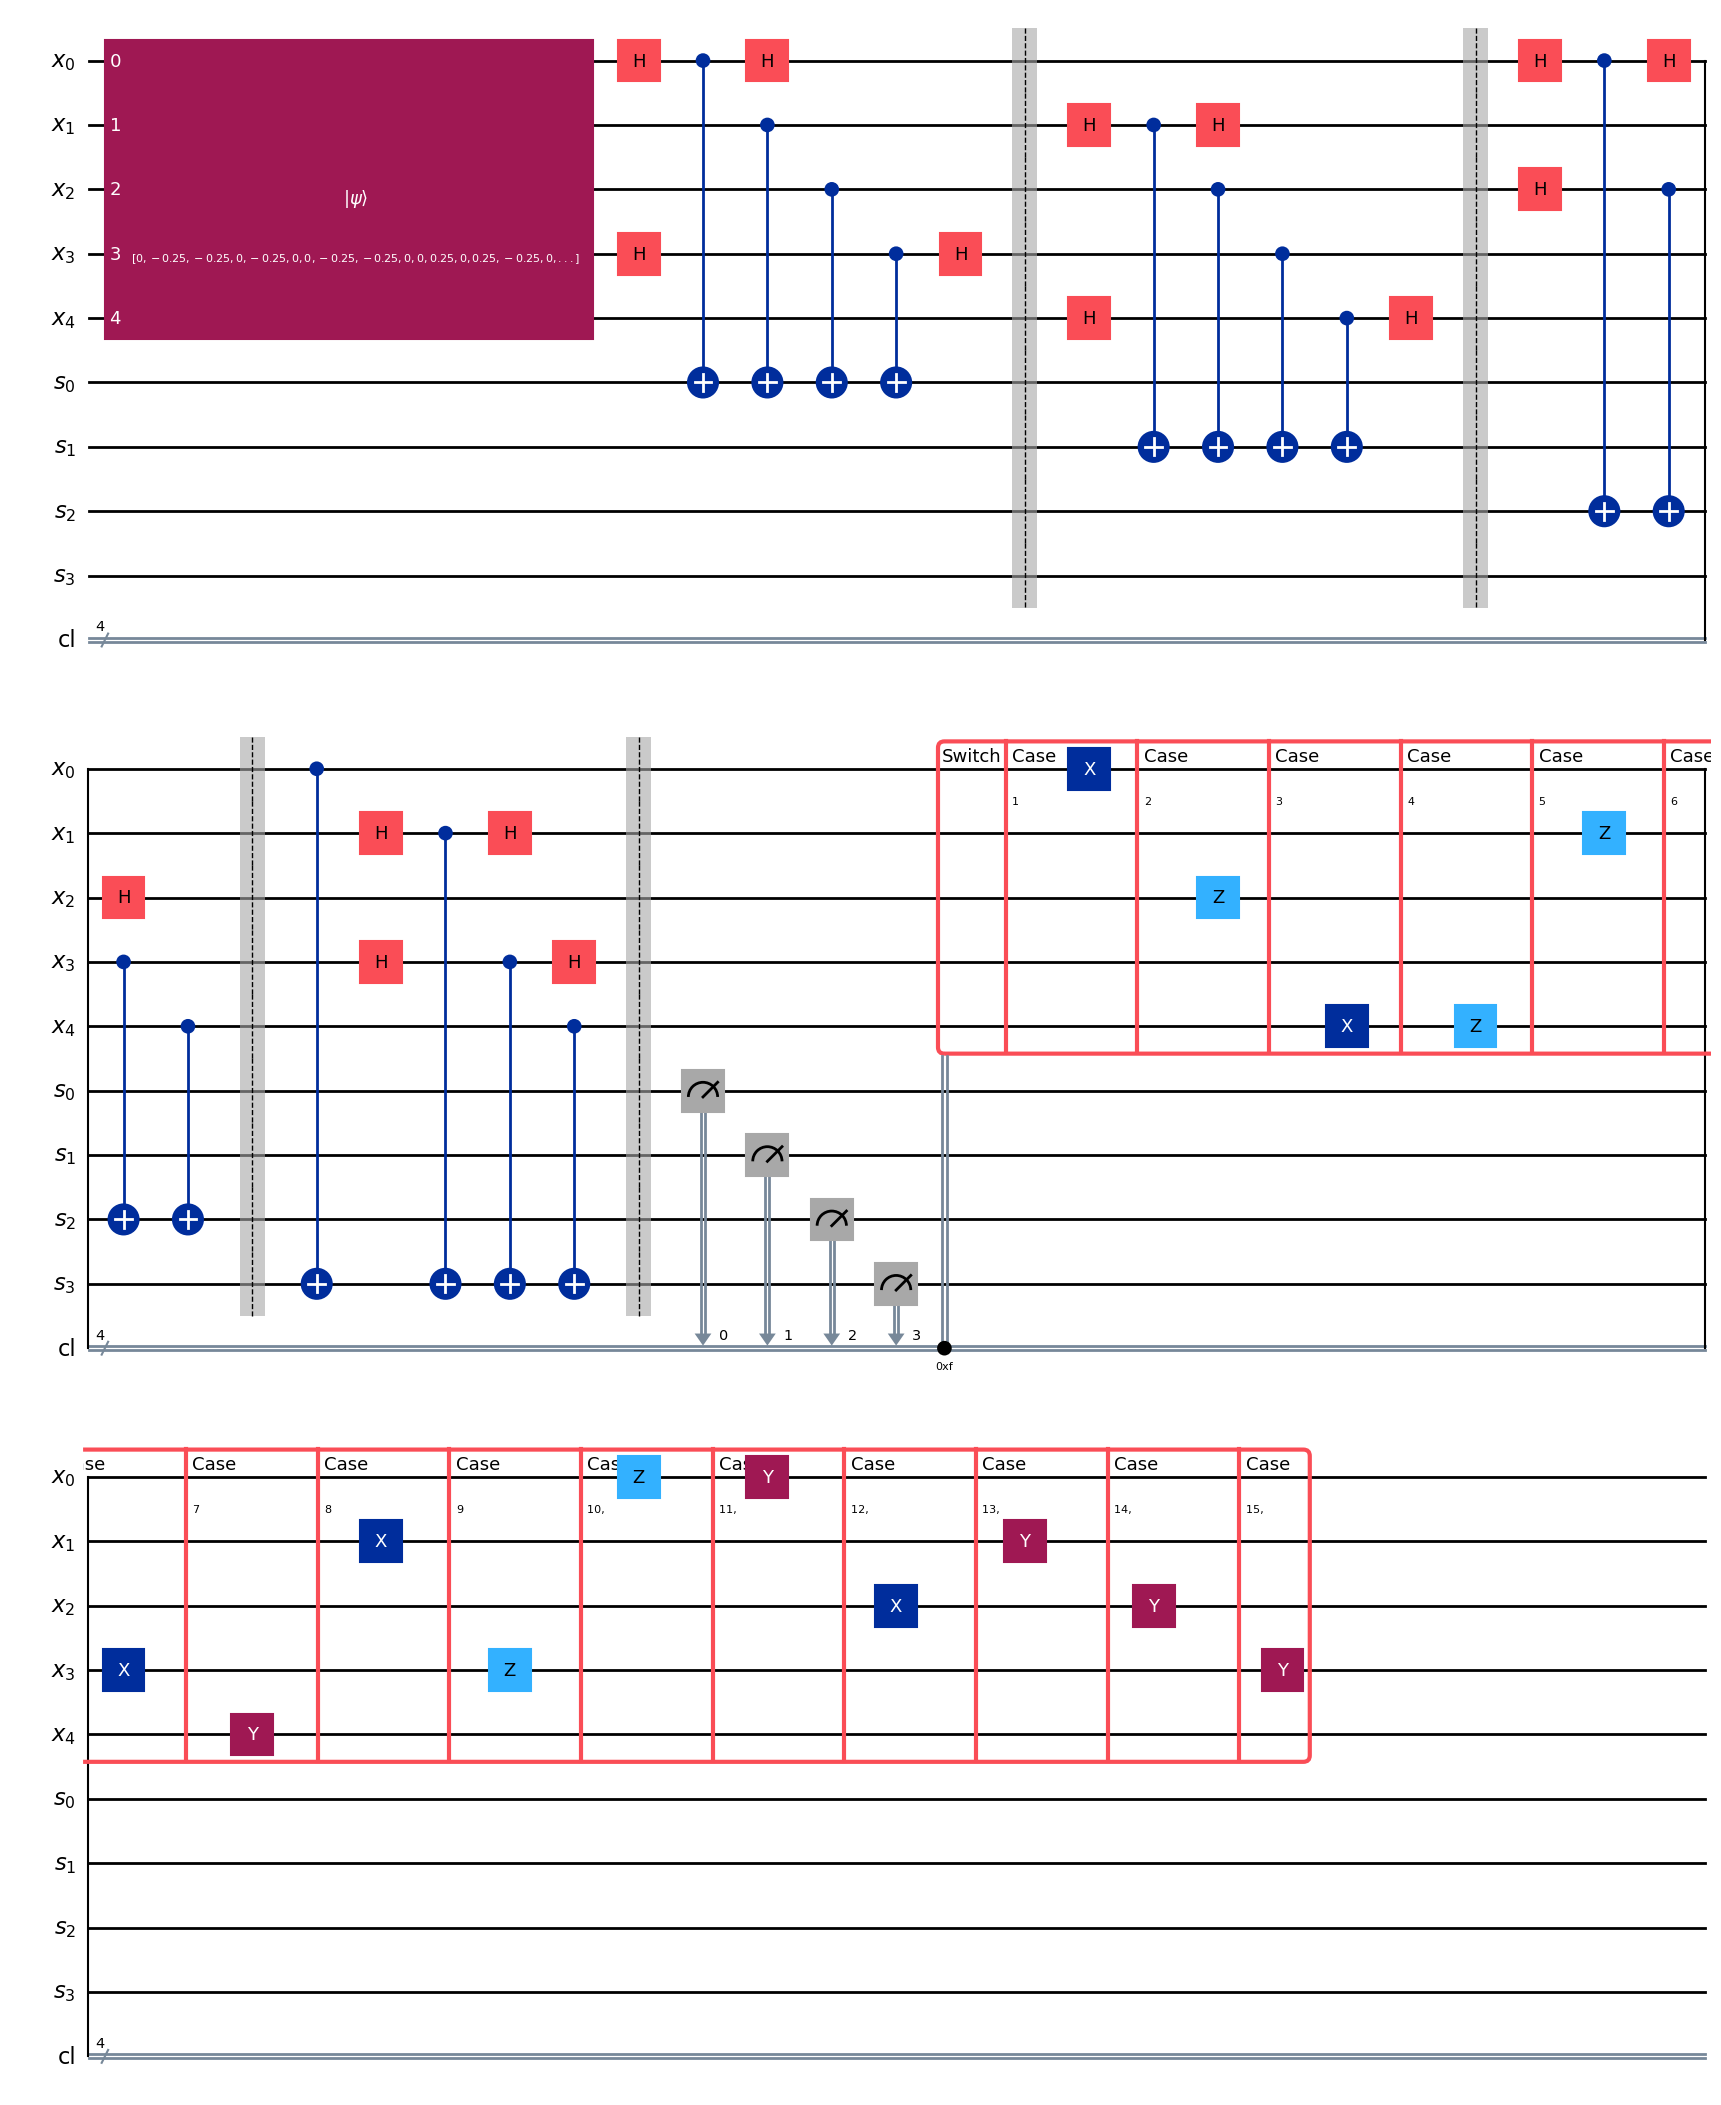

In [10]:
def decoder(qc,register,data):
    """
    Recovers a logical state for the 5 qubit code for a state that is distance <= 1 from a valid logical state.

    qc: a quantum register
    register: (quantum register) the 5 physical qubits storing our data
    data: a 4 bit classical register storing the result of our syndrome measurement
    """

    # In each case, use the dictionary we introduced earlier to determine the appropriate 
    # sequence of X,Y, or Z gates to apply to undo the error.

    # Depending on the result of the syndrome measurement, stored in 'data'
    with qc.switch(data) as case:
        for i in range(1,len(decoding_dictionary)+1):
            with case(i): 
                # Print out the binary representation of the value in 'data'
                syndrome_value = f"{i:04b}"
                # Decode which error occured using our dictionary
                decoder = decoding_dictionary[syndrome_value]

                # Apply the same error operator again, since they all square to the identity, to recover the correct state
                for j in range(len(decoder)):
                    if decoder[j] == 'X':
                        qc.x(register[j])
                    if decoder[j] == 'Y':
                        qc.y(register[j])
                    elif decoder[j] == 'Z':
                        qc.z(register[j])


## Test Case: (no error applied)

# Initialize the circuit
register = QuantumRegister(size = 5,name = 'x')
syndrome = AncillaRegister(size = 4, name = 's')
syndrome_data = ClassicalRegister(size = 4,name = 'cl')
qc = QuantumCircuit(register,syndrome,syndrome_data)

# Stabilizer group for 5 qubit code
stabilizer_group = ['XZZXI','IXZZX','XIXZZ','ZXIXZ']

# Prepare the logical state 0 or 1
prepare_logical_state(qc,register,1)

# Do all the syndrome checks
syndrome_check(qc,register,syndrome,stabilizer_group)

# Measure the syndrome qubits
qc.measure(syndrome,syndrome_data)

# Correct the error
decoder(qc,register,syndrome_data)

qc.draw(output='mpl')

Finally, we write a function that packages everything together, including initializing the qubit, applying an error, and decoding that error.

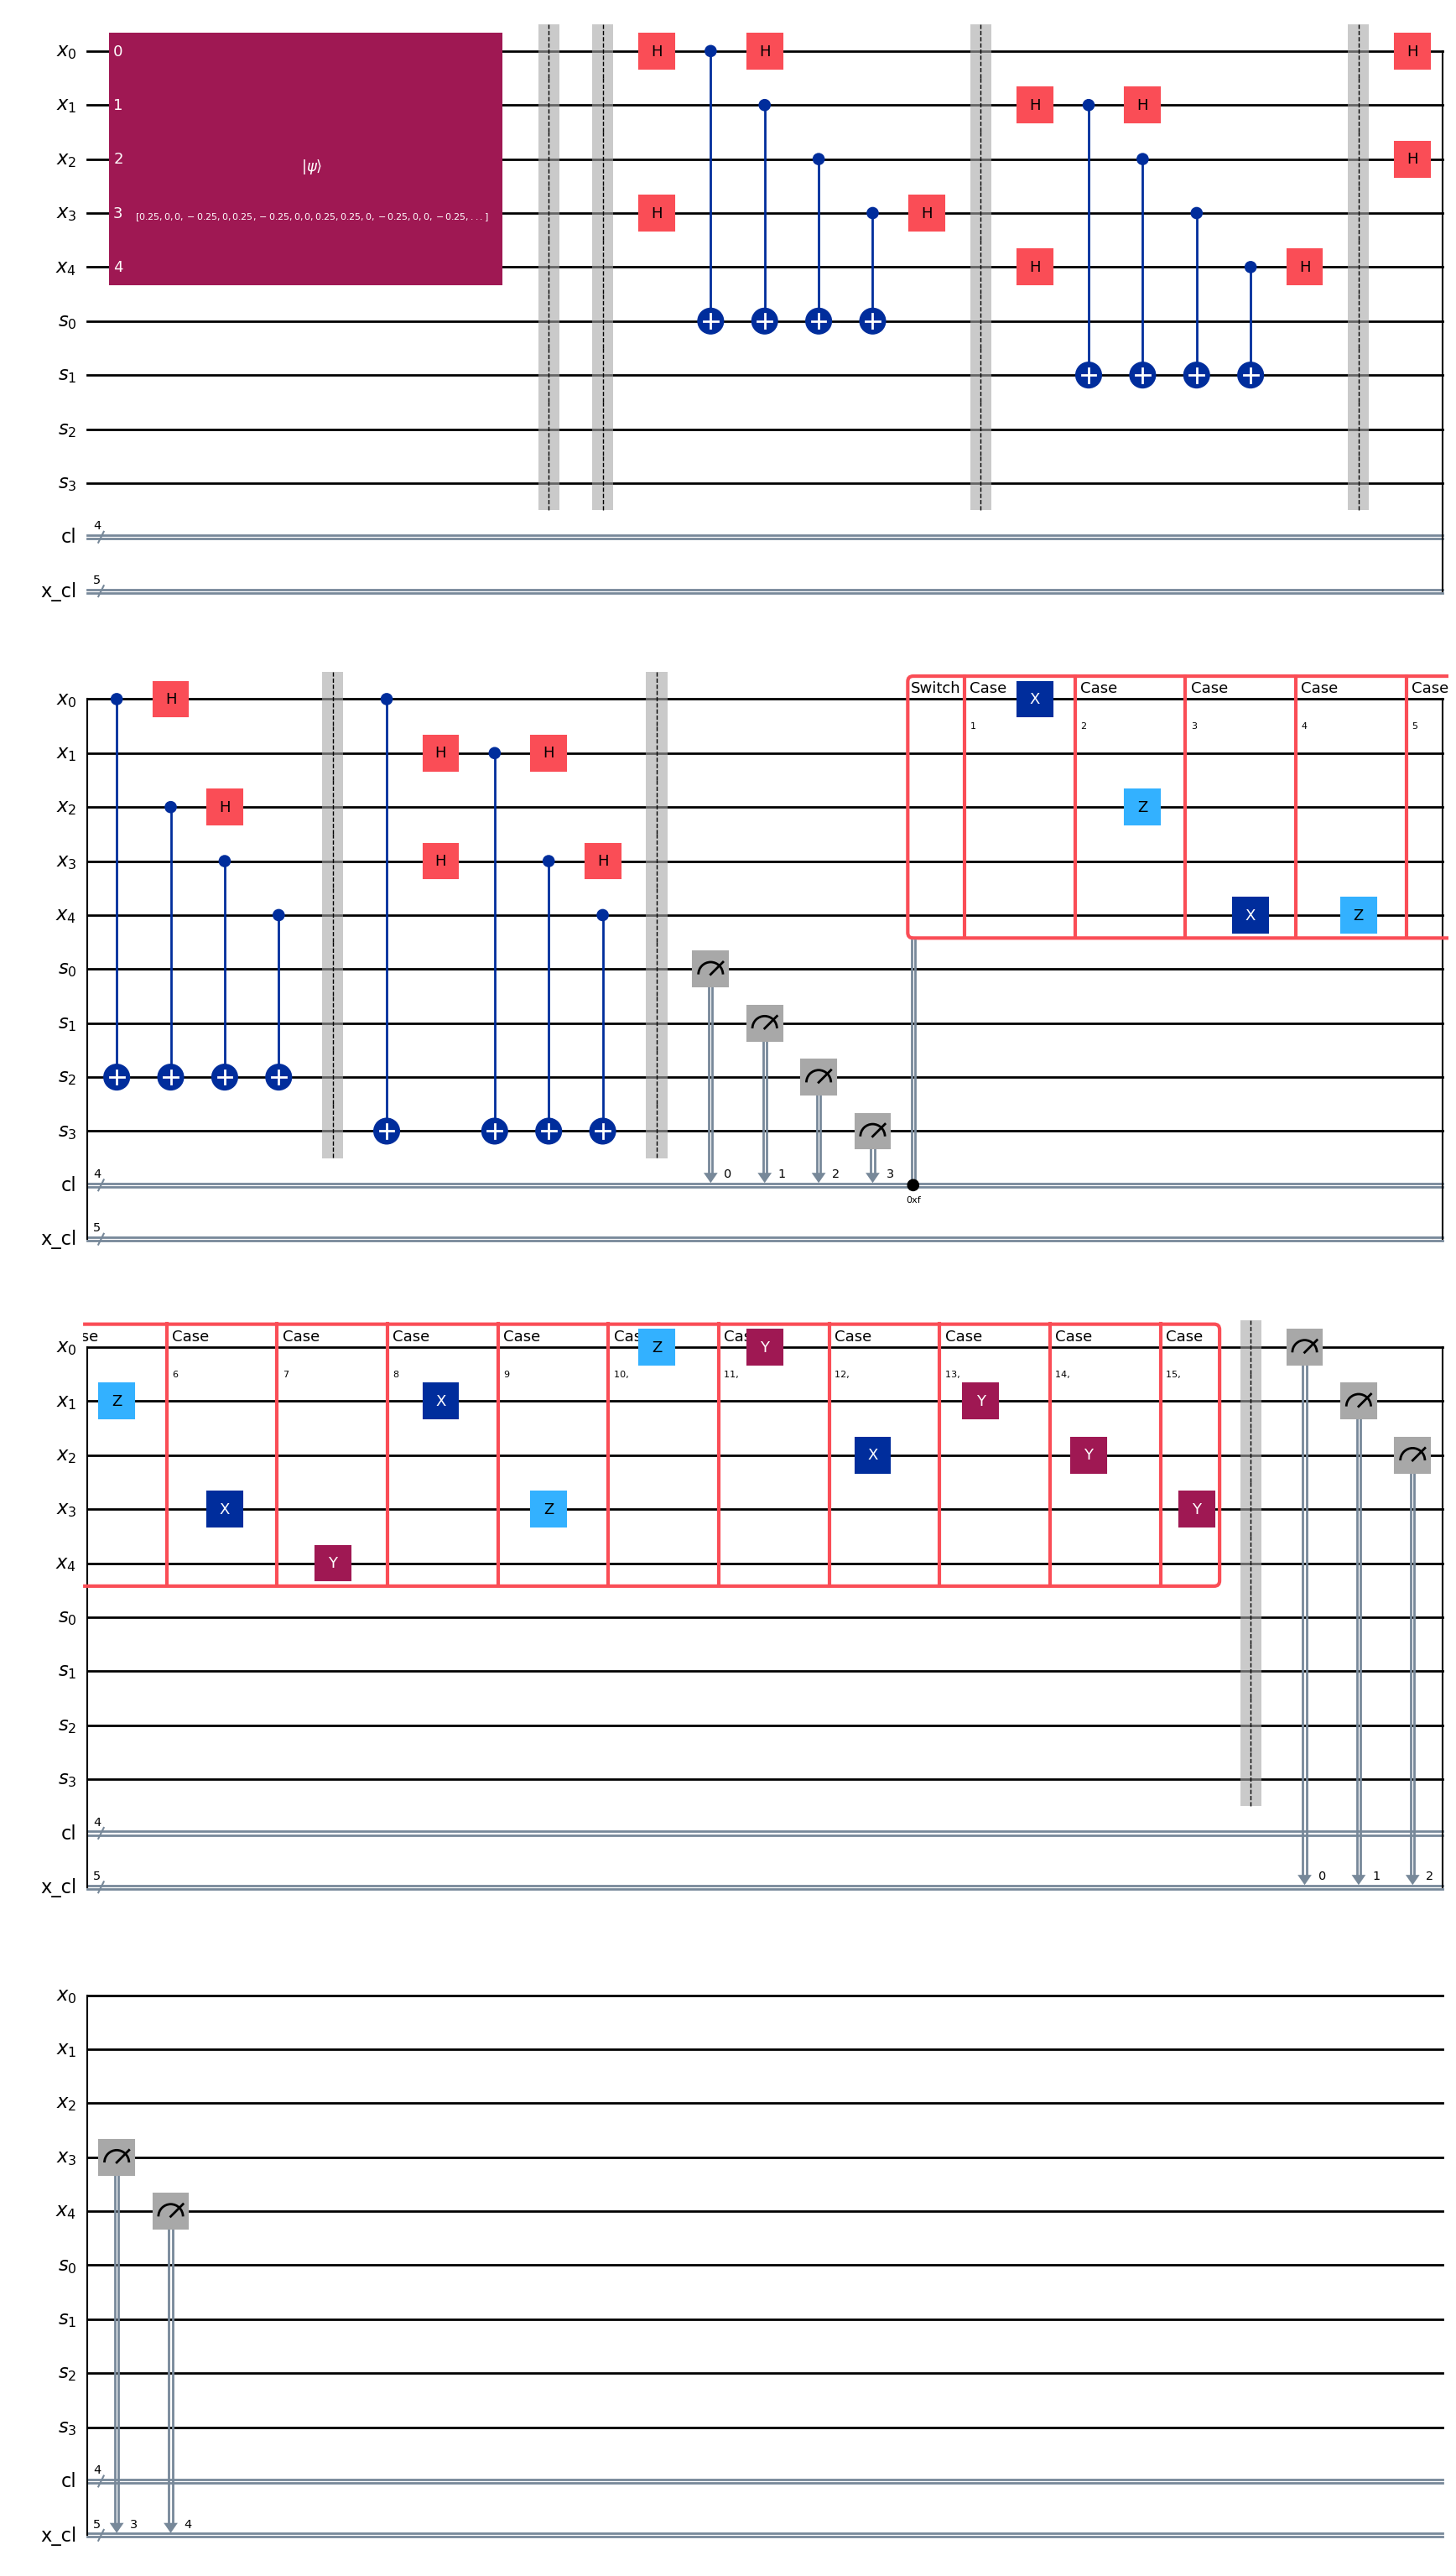

In [11]:
def final_circuit(initial_value,error_probability):
    """
    Initializes 5 physical qubits to the |0_L> or |1_L> state, then applies a random Pauli error channel to each qubit,
    and then uses the 5 qubit code stabilizers to try to detect and correct the error.

    initial_value: (Int) 0 or 1 corresponding to whether the initial state should be in the |0_L> or |1_L> state.
    error_probaility: (float) a value between 0 and 1/3 corresponding to the error rate.

    Returns: a quantum circuit on which this is all implemented.
    """

    ## Initialize the quantum circuit:
    # 5 physical qubits
    register = QuantumRegister(size = 5,name = 'x')
    # 4 syndrome (ancilla) qubits
    syndrome = AncillaRegister(size = 4, name = 's')
    # a 4-bit classical register to store syndrome measurements
    syndrome_data = ClassicalRegister(size = 4,name = 'cl')
    # a 5-bit classical register to store the final state of the physical qubits after error correction
    register_data = ClassicalRegister(size = 5,name = 'x_cl')
    # the quantum circuit
    five_qubit_QEC_circuit = QuantumCircuit(register,syndrome,syndrome_data,register_data)

    # Stabilizer group for the 5 qubit code
    stabilizer_group = ['XZZXI','IXZZX','XIXZZ','ZXIXZ']

    # Prepare the correct logical state
    prepare_logical_state(five_qubit_QEC_circuit,register,initial_value)

    five_qubit_QEC_circuit.barrier()

    
    # Apply a Pauli error to each qubit with the appropriate probability
    for k in range(len(register)):
        Pauli_error_channel(five_qubit_QEC_circuit,register[k],error_probability)

    five_qubit_QEC_circuit.barrier()

    # Perform the syndrome checks
    syndrome_check(five_qubit_QEC_circuit,register,syndrome,stabilizer_group)
    # Measure the syndrome qubits
    five_qubit_QEC_circuit.measure(syndrome,syndrome_data)
    # Decode the error and correct for it
    decoder(five_qubit_QEC_circuit,register,syndrome_data)

    five_qubit_QEC_circuit.barrier()

    # Measure the 5 physical qubits
    five_qubit_QEC_circuit.measure(register,register_data)

    # Return the quantum circuit

    return five_qubit_QEC_circuit

## Test Case:

qc = final_circuit(0,0.05)
qc.draw(output='mpl')

Finally, we ensure that our implementation corrects errors at the expected rate.

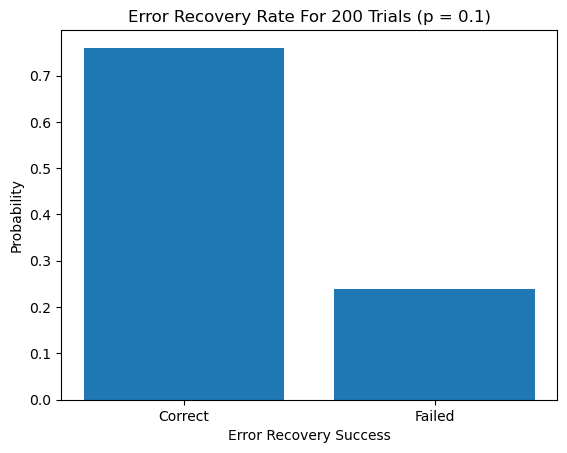

Correctly Decoded:  152 / 200
Failed to Decode:  48 / 200



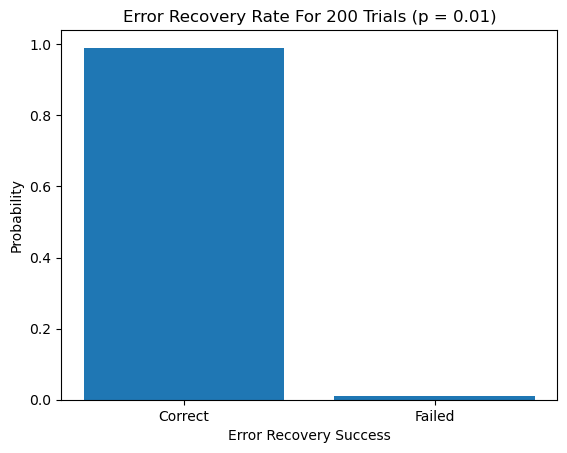

Correctly Decoded:  198 / 200
Failed to Decode:  2 / 200



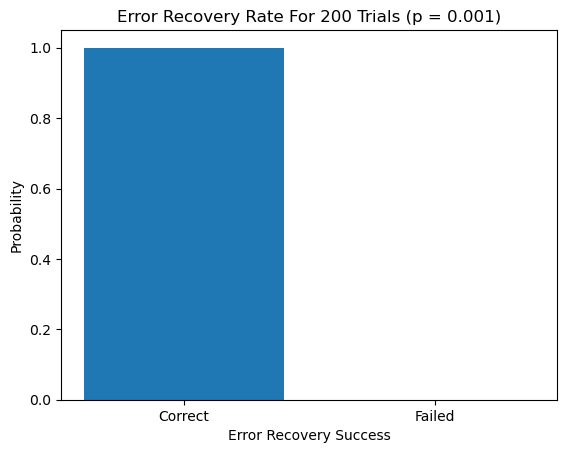

Correctly Decoded:  200 / 200
Failed to Decode:  0 / 200



In [12]:
# Total number of trials to run for each error rate
trials = 200

# List of error rates to test our circuit for.
error_probabilities = [0.1,0.01,0.001]

# Logical state to which the circuit is initialized
initial_value = 1

# For each error rate
for error_probability in error_probabilities:

    # Store number of times the correct state was decoded
    correct_decoding = 0
    failed_decoding = 0

    # For each trial...
    for i in range(trials):
        
        # Create a quantum circuit implementing our 5 qubit code on a state initialized to the correct logical state
        # that has an error applied with the chosen probability
        quantum_circuit = final_circuit(initial_value,error_probability)

        # Simulate the quantum circuit
        simulator = AerSimulator()
        
        # Transpile the circuit for the backend
        compiled_circuit = transpile(quantum_circuit, simulator)
        
        # Run the circuit
        job = simulator.run(compiled_circuit, shots=1)
        
        # Get the measurement counts
        counts = job.result().get_counts()

        # To check if correct decoding was performed, we use the fact that each
        # computational basis state for |0_L> (|1_L>)  has an even (odd) number of 1's in its binary representation,
        # so we count how many 1's appear in the measured state to see if this agrees with the state to which our circuit
        # was initialized.
        for x in counts.keys():  
            if x[:5].count('1') % 2 == initial_value:
                correct_decoding += 1
            else:
                failed_decoding += 1

    # And finally we plot the statistics
    
    plt.figure()
    plt.bar(['Correct','Failed'],[correct_decoding/trials,failed_decoding/trials])
    plt.xlabel('Error Recovery Success')
    plt.title(f'Error Recovery Rate For {trials} Trials (p = {error_probability})')
    plt.ylabel('Probability')
    plt.show()
    plt.close()
    
    print('Correctly Decoded: ',correct_decoding,'/',trials)
    print('Failed to Decode: ',failed_decoding,'/',trials)
    
    print()

We see that for error rates sufficiently small, we obtain a correct decoding a high percentage of the time. Comparing these success rates with our initial tests on the Pauli channel when we computed the expected success of decoding, we find agreement modulo a small caveat. For $p = 0.1$, for example, we expect to recover the correct state about 52% of the time, since more than 1 error occurs about 48% of the time; however, these simulations seem to suggest that we get the correct answer about 76% of the time. The reason for this apparent discrepancy is that, when more than 1 error occurs, it is more-or-less a coin flip as to which state |0> or |1> the error correction circuit will decode to. This means that of the 48% of the time we expect to not be able to decode correctly, 24% will coincidentally decode to the "correct" initial state, and 24% will decode to the incorrect state. If we expect a failure probability $q$, we generally expect that under this kind of empirical test, the failure rate will be $<q$, in agreement with our findings.